# Efficient Portfolios
###### Petko Vladimirov Stoyanov - 21208084 - UCD Michael Smurfit Business School

## Exercise 1 - 40 marks
Analyse two models for the input of historical data.

### Model 1
Download weekly price of the stock indices [27-Jan-2020, 23-Mar-2020] (9 prices, 8 returns):

   - US: Dow Jones Industrial `^DJI`, S&P500 `^GSPC`
   - UK: FTSE100 `^FTSE`
   - Europe: MSCI Eurozone `EZU`
   - Gold `GLD`

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import scipy.optimize as sco

warnings.filterwarnings('ignore')

In [4]:

ticker_list = ['^DJI', '^GSPC', '^FTSE', 'EZU', 'GLD']
model1 = yf.download(ticker_list, start="2020-01-27", end="2020-03-23", interval="1wk")['Adj Close']
model1

[*********************100%***********************]  5 of 5 completed


,EZU,GLD,^DJI,^FTSE,^GSPC
Date,,,,,
2020-01-27,38.602440,149.330002,28256.029297,7286.000000,3225.520020
2020-02-03,39.699100,147.789993,29102.509766,7466.700195,3327.709961
2020-02-10,39.994720,149.000000,29398.080078,7409.100098,3380.159912
2020-02-17,39.584660,154.699997,28992.410156,7403.899902,3337.750000
2020-02-24,35.751118,148.380005,25409.359375,6580.600098,2954.219971
2020-03-02,35.293381,157.550003,25864.779297,6462.600098,2972.370117
2020-03-09,29.018583,143.279999,23185.619141,5366.100098,2711.020020
2020-03-16,25.261330,140.110001,19173.980469,5190.799805,2304.919922


### Model 2
Download weekly price of the stock indices [Jan-2015, Dec-2019]:

   - US: Dow Jones Industrial `^DJI`, S&P500 `^GSPC`
   - UK: FTSE100 `^FTSE`
   - Europe: MSCI Eurozone `EZU`
   - Gold `GLD`

In [5]:
model2 = yf.download(ticker_list, period="5y", start="2015-01-01", interval="1wk")['Adj Close']
model2.dropna(inplace=True)
model2

[*********************100%***********************]  5 of 5 completed


,EZU,GLD,^DJI,^FTSE,^GSPC
Date,,,,,
2014-12-29,30.436684,114.080002,17832.990234,6547.799805,2058.199951
2015-01-05,29.382240,117.260002,17737.369141,6501.100098,2044.810059
2015-01-12,30.177261,122.519997,17511.570312,6550.299805,2019.420044
2015-01-19,30.587322,124.230003,17672.599609,6832.799805,2051.820068
2015-01-26,30.696114,123.449997,17164.949219,6749.399902,1994.989990
...,...,...,...,...,...
2022-01-24,46.599998,167.100006,34725.468750,7466.100098,4431.850098
2022-01-31,47.500000,168.860001,35089.738281,7516.399902,4500.529785
2022-02-07,46.570000,173.809998,34738.058594,7661.000000,4418.640137


### Calculate expected annual returns and covariance matrix.

In order to calculate the returns of a certain stock we will use the adjusted close price of each period.
Annual (total) returns: $R_a = \frac{R_n - R_0}{R_0}$

In [6]:
def annual_return(time_series):
    return (time_series[-1]-time_series[0])/time_series[0]

def get_log_return(time_series):
    return np.log(1+time_series.pct_change())

def clear_model(model):
    model_clear = model
    if type(model.index) is not pd.MultiIndex:
        model_clear.index = pd.MultiIndex.from_tuples(zip(model.index.year,model.index),names=['Year','Date'])
    # model_clear.columns = model_clear.columns.droplevel(1)
    return model_clear

def get_returns(model):
    returns = model.groupby('Year').count()
    for ticker in model:
        for year in returns.index:
            returns.loc[year,ticker] = annual_return(model.loc[year,ticker])
    return returns

def get_returns_adjusted(model):
    '''
    Returns two dataframes with the annual returns and the mean of log returns
        adjusted for the last period price when available
    '''
    returns = model.groupby('Year').count()
    log_returns = model.groupby('Year').count()
    for ticker in model:
        for year in returns.index:
            if year-1 in returns.index:
                prev_close = model.loc[year-1,ticker].iloc[-1:]
                annual_series = prev_close.iloc[-1:].append(model.loc[year,ticker])
                returns.loc[year,ticker] = annual_return(annual_series)
                log_returns.loc[year,ticker] = get_log_return(annual_series).mean()
            else:
                returns.loc[year,ticker] = annual_return(model.loc[year,ticker])
                log_returns.loc[year,ticker] = get_log_return(model.loc[year,ticker]).mean()

    return returns, log_returns

Annual Returns and Expected annual returns:

In [7]:
models = {'model 1': model1, 'model 2': model2}
expected_returns_dict = {'model 1': None, 'model 2': None}

for model in models:
    print(model, 'Annual returns:')
    model_clear = clear_model(models[model])
    model_returns, model_log_returns = get_returns_adjusted(model_clear)
    display(model_returns)
    print(model,'Expected annual returns (mean of log returns):')
    expected_return = model_log_returns.mean().dropna()
    expected_returns_dict[model] = expected_return
    display(expected_return)

model 1 Annual returns:


,EZU,GLD,^DJI,^FTSE,^GSPC
Year,,,,,
2020,-0.345603,-0.061742,-0.32142,-0.287565,-0.285411


model 1 Expected annual returns (mean of log returns):


EZU     -0.060577
GLD     -0.009104
^DJI    -0.055393
^FTSE   -0.048438
^GSPC   -0.048007
dtype: float64

model 2 Annual returns:


,EZU,GLD,^DJI,^FTSE,^GSPC
Year,,,,,
2014,0.000000,0.000000,0.000000,0.000000,0.000000
2015,-0.017495,-0.110624,-0.022877,-0.046657,-0.006928
2016,0.018633,0.080327,0.134150,0.144258,0.095350
2017,0.278903,0.128091,0.250808,0.076301,0.194200
2018,-0.155695,-0.017873,-0.052027,-0.110617,-0.052988
2019,0.213052,0.201087,0.221981,0.114810,0.277617
2020,0.078226,0.222816,0.068853,-0.152432,0.161126
2021,0.136426,-0.041489,0.187275,0.143023,0.268927
2022,-0.026992,0.022812,-0.038638,0.029695,-0.061091


model 2 Expected annual returns (mean of log returns):


EZU      0.000719
GLD      0.001326
^DJI     0.001098
^FTSE    0.000752
^GSPC    0.001036
dtype: float64

Covariance matrix is calculated on the log returns matrix:

In [8]:
covariances = {'model 1': None, 'model 2': None}

for model in models:
    log_returns = get_log_return(models[model]).dropna()
    matrix = log_returns.cov()
    print(model, 'Covariance matrix:')
    display(matrix)
    covariances[model] = log_returns.cov()

model 1 Covariance matrix:


,EZU,GLD,^DJI,^FTSE,^GSPC
EZU,0.007225,0.003448,0.006419,0.005557,0.005606
GLD,0.003448,0.002642,0.002821,0.003133,0.002350
^DJI,0.006419,0.002821,0.007576,0.003957,0.006624
^FTSE,0.005557,0.003133,0.003957,0.005689,0.003526
^GSPC,0.005606,0.002350,0.006624,0.003526,0.005831


model 2 Covariance matrix:


,EZU,GLD,^DJI,^FTSE,^GSPC
EZU,0.000813,0.000096,0.000588,0.000497,0.000547
GLD,0.000096,0.000380,0.000063,0.000051,0.000059
^DJI,0.000588,0.000063,0.000625,0.000408,0.000569
^FTSE,0.000497,0.000051,0.000408,0.000514,0.000377
^GSPC,0.000547,0.000059,0.000569,0.000377,0.000550


### Optimal portfolio in each case

In order to calculate the optimal portfolio, there are different approaches, but we are going to follow the min-variance portfolio, while visualizing the efficient frontier for the different options

$$ E_{ret} = w_1·\sigma_1 + w_2·\sigma_2$$

$$ P_{var} = w_1^2·\sigma_1^2 + w_2^2·\sigma_2^2 + 2·w_1·w_2·Cov_{1,2}$$

Upper formula is calculated for a portfolio with 2 assets, but applying algebraic functions we can extend it to a larger portfolio.

We will also make use of the Risk Free rate defined by Fama and French to apply to the 3 Factor Model bafore calculating the optimal portfolios. [Source: [Weekly Fama/French 3 Factors](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)]


In [9]:
fff = pd.read_csv('F-F_Research_Data_Factors_weekly.csv', skiprows=3, skipfooter=1)
fff['Date'] = pd.to_datetime(fff.iloc[:,0],format='%Y%m%d')
rf = fff[['Date', 'RF']]
model1_rf = rf[(rf['Date']>='2020-01-27') & (rf['Date']<= '2020-03-23')]
# display(model1_rf)
print(f'Model 1 RF (mean value): {round(model1_rf.mean()[0],3)}')
model2_rf = rf[(rf['Date']>='2015-01-01') & (rf['Date']<= '2019-12-31')]
# display(model2_rf)
print(f'Model 2 RF (mean value): {round(model2_rf.mean()[0],3)}')

risk_free_rates = {'model 1':model1_rf, 'model 2':model2_rf}

Model 1 RF (mean value): 0.031
Model 2 RF (mean value): 0.02


To estimate the optimal portfolio in each case, we can either follow a random approach, generating a large number of portfolios, or directly minimizing the function.
In both cases we will calculate the minimum variance portfolio, and the maximum sharpe ratio portfolio.

$$ S = \frac{R_p-R_f}{\sigma_p} $$

        1. Generating 100000 portfolios with different weights

In [10]:
def expected_return(mean_returns, weight):
    return np.dot(mean_returns, weight)

def rand_weigh(size_r):
    rnd = np.random.random(size_r)
    rnd /= rnd.sum()
    return rnd

def portfolio_var(weights_p, cov_matrix, periods):
    return np.sqrt(np.dot(weights_p.T, np.dot(cov_matrix*periods,weights_p)))

model 1 (Rf: 0.031):
---------------MIN-VARIANCE----------------
Variance:0.3816	Return:-0.018	Sharpe:-0.04806355725007828
Weights:[0.0059 0.7888 0.0857 0.0282 0.0914]
---------------MAX SHARPE RATIO----------------
Variance:0.3832	Return:-0.0171	Sharpe:-0.045418578280729004
Weights:[0.0402 0.8181 0.0536 0.043  0.0451]


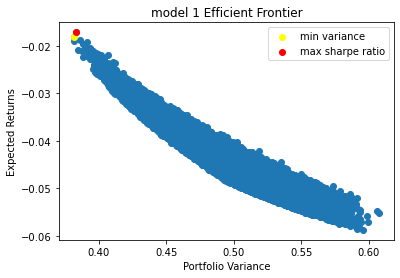

model 2 (Rf: 0.02):
---------------MIN-VARIANCE----------------
Variance:0.1107	Return:0.0011	Sharpe:0.008240430520038741
Weights:[0.0011 0.5247 0.0481 0.2669 0.1592]
---------------MAX SHARPE RATIO----------------
Variance:0.1158	Return:0.0012	Sharpe:0.008885417804827645
Weights:[0.0007 0.6791 0.212  0.0507 0.0575]


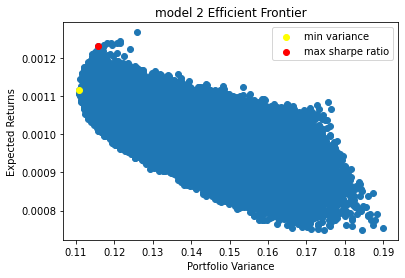

In [11]:
# generating 100000 different portfolios
for model in covariances:
    returns = []
    variances = []
    weights = []
    sharpe_ratios = []
    covariance = covariances[model]
    rfr = risk_free_rates[model].mean()[0]
    print(f'{model} (Rf: {round(rfr,3)}):')
    rfr = np.log(1+rfr)  # for calculations we are using the log, like we did with the returns
    for i in range(100000):
        w = rand_weigh(len(covariance))
        weights.append(w)
        e = expected_return(expected_returns_dict[model],w)
        returns.append(e)
        v = portfolio_var(w, covariance, 52)  # 52 weeks annualy
        variances.append(v)
        sharpe_ratios.append((e-rfr/100)/v)
    plt.scatter(variances, returns)
    min_v = min(variances)
    index = variances.index(min_v)
    min_ret = returns[index]
    min_w = weights[index]
    print('---------------MIN-VARIANCE----------------')
    print(f'Variance:{round(min_v,4)}\tReturn:{round(min_ret,4)}\tSharpe:{sharpe_ratios[index]}\nWeights:{np.around(min_w,4)}')
    s = max(sharpe_ratios)
    s_index = sharpe_ratios.index(s)
    print('---------------MAX SHARPE RATIO----------------')
    print(f'Variance:{round(variances[s_index],4)}\tReturn:{round(returns[s_index],4)}\tSharpe:{sharpe_ratios[s_index]}\nWeights:{np.around(weights[s_index],4)}')
    plt.scatter(min_v, min_ret, c = 'yellow',label='min variance', cmap='coolwarm')
    plt.xlabel('Portfolio Variance')
    plt.ylabel('Expected Returns')
    plt.title(f'{model} Efficient Frontier')
    plt.scatter(variances[s_index], returns[s_index], c = 'red', label='max sharpe ratio')
    # plt.scatter(0,rfr,c='g',label='RF rate')
    plt.legend()
    plt.show()


This approach is not exact, as it is based on randomness it will always give us a different result, although it will be very close and it will minimise the variance as tested.

        2. Apply optimization to maximize the Sharpe Ratio or minimize the variance separately


In [12]:
def calculate_sharpe(weights_s, returns_s, covariance_s, periods, rf_s):
    return (-expected_return(returns_s, weights_s)-rf_s)/portfolio_var(weights_s, covariance_s, periods)

def minimize_var(log_returns_matrix, covariance_matrix, rf_matrix, n_periods, weights_arr, bounds, contraints):
    optv = sco.minimize(portfolio_var, weights_arr, args=(covariance_matrix, n_periods), method='SLSQP', bounds=bounds, constraints=contraints)  # variance optimization
    w_v = optv['x']  # weights of variance minimization
    var_v = portfolio_var(w_v, covariance_matrix, n_periods)
    ret_v = expected_return(log_returns_matrix, w_v)
    sr_v = -calculate_sharpe(w_v, log_returns_matrix, covariance_matrix, n_periods, rf_matrix)
    print('**********Min-Variance**********')
    print(f'Variance:{round(var_v,4)}\tReturn:{round(ret_v,4)}\nWeights: {np.around(w_v,4)}')
    print(f'Sharpe Ratio:{sr_v}')
    return w_v

def maximize_sharpe(log_returns_matrix, covariance_matrix, rf_matrix, n_periods, weights_arr, bounds, contraints):
    opts = sco.minimize(calculate_sharpe, weights_arr, args=(log_returns_matrix, covariance_matrix, n_periods, rf_matrix), method='SLSQP', bounds=bounds, constraints=contraints)  # sharpe optimization
    w_s = opts['x']  # weights of sharpe maximization
    var_s = portfolio_var(w_s, covariance_matrix, n_periods)
    ret_s = expected_return(ret, w_s)
    sr_s = -calculate_sharpe(w_s, ret, covariance_matrix, n_periods, rf_matrix)
    print('\n**********Sharpe Ratio**********')
    print(f'Variance:{round(var_s,4)}\tReturn:{round(ret_s,4)}\nWeights: {np.around(w_s,4)}')
    print(f'Sharpe Ratio:{sr_s}\n')
    return w_s


constraint = {'type':'eq', 'fun':lambda x: np.sum(x)-1}
size = len(ticker_list)
bound = tuple((0,1) for x in range(size))
eq_weights = np.array(size*[1./size,])

for model in covariances:
    rf = risk_free_rates[model].mean()[0]
    cov = covariances[model]
    ret = expected_returns_dict[model]
    n = 52
    print(f'\n{model} (Rf: {round(rf,4)}):')
    minimize_var(ret, cov, rf, n, eq_weights, bound, constraint)
    maximize_sharpe(ret, cov, rf, n, eq_weights, bound, constraint)


model 1 (Rf: 0.0306):
**********Min-Variance**********
Variance:0.3691	Return:-0.0121
Weights: [0.     0.9225 0.     0.     0.0775]
Sharpe Ratio:0.050137756743618735

**********Sharpe Ratio**********
Variance:0.3707	Return:-0.0091
Weights: [0. 1. 0. 0. 0.]
Sharpe Ratio:0.058058652324823525


model 2 (Rf: 0.0205):
**********Min-Variance**********
Variance:0.1102	Return:0.0011
Weights: [0.     0.5511 0.     0.2661 0.1828]
Sharpe Ratio:0.19587008727078775

**********Sharpe Ratio**********
Variance:0.1102	Return:0.0011
Weights: [0.     0.5577 0.     0.2527 0.1896]
Sharpe Ratio:0.19589438469101472



### Which model is correct. Why?

We cannot say that one model or the other is correct or not. Instead of that we should be talking about which model is more accurate. In that case, it is obvious that the second model, that contains more data points is probably the most accurate.
The first model only depicts the starting period of a crisis, where all the stock prices were falling. Therefore we could say that the first model is biased, as it only contains a small amount of data in a particular period, which is not fair to the full model.
On the other hand, the second model contains data of 5 years, which gives us a bigger picture of the market, and more trustworthy. After all, with more data available to model, more precise will be the final result. In this model we find a variety of returns, and as we can see in the efficient frontier (Figure 2), it resembles more the expected efficient frontier of a portfolio.

As for the two approaches followed in this part, the second one, using optimization is definitely more accurate as it can either minimize the variance or maximize the sharpe ratio. In contrast, the generative (first approach), may be more easily done/visualized, but it will never obtain the same results. For this matter, the second model gives us much better results, in fact, both minimum variance portfolio and maximum sharpe are practically the same. As we can see in the last data displayed, we can obtain a log-return of 0.0011 with a variance of 0.112, far better results than the model 1, where return is negative in its peak.

## Exercise 2 - 60 Marks

Use shrinkage method to model the data

### Calculate annual covariance matrix with the estimated shrinkage

In [13]:
import numpy as np
import nonlinshrink as nls
from sklearn.covariance import LedoitWolf

In [23]:

# for model in models:
model = 'model 1'
sh_returns = get_log_return(models[model]).dropna()
p = len(sh_returns.columns)  # number of variables
n = len(sh_returns)  # number of observations
# sigma = np.eye(p, p)
# data = np.random.multivariate_normal(np.zeros(p), sigma, n)
sigma_tilde = LedoitWolf().fit(sh_returns)
# sigma_tilde = nls.shrink_cov(sh_returns)
# sh_returns
display(sigma_tilde.covariance_)  # shrinkage covariance matrix

array([[0.0060047 , 0.00250266, 0.0046593 , 0.00403345, 0.00406926],
       [0.00250266, 0.00267829, 0.00204752, 0.00227408, 0.00170557],
       [0.0046593 , 0.00204752, 0.00625939, 0.00287242, 0.00480817],
       [0.00403345, 0.00227408, 0.00287242, 0.0048898 , 0.00255923],
       [0.00406926, 0.00170557, 0.00480817, 0.00255923, 0.00499292]])

In [ ]:

# for model in models:
model = 'model 2'
sh_returns = get_log_return(models[model]).dropna()
sigma_tilde = nls.shrink_cov(sh_returns)
sigma_tilde  # shrinkage covariance matrix

<div class="alert alert-block alert-warning">
We cannot use the designated shrinkage method for model 1
<div>

In [25]:
sh_covariances = {}

for model in models:
    sh_returns = get_log_return(models[model]).dropna()
    sh_covariances[model] = LedoitWolf().fit(sh_returns).covariance_

sh_covariances

{'model 1': array([[0.0060047 , 0.00250266, 0.0046593 , 0.00403345, 0.00406926],
        [0.00250266, 0.00267829, 0.00204752, 0.00227408, 0.00170557],
        [0.0046593 , 0.00204752, 0.00625939, 0.00287242, 0.00480817],
        [0.00403345, 0.00227408, 0.00287242, 0.0048898 , 0.00255923],
        [0.00406926, 0.00170557, 0.00480817, 0.00255923, 0.00499292]]),
 'model 2': array([[7.95602177e-04, 8.93942642e-05, 5.48014136e-04, 4.63478548e-04,
         5.09687810e-04],
        [8.93942642e-05, 3.91614622e-04, 5.83463326e-05, 4.71586806e-05,
         5.52744635e-05],
        [5.48014136e-04, 5.83463326e-05, 6.20518236e-04, 3.80392324e-04,
         5.30609967e-04],
        [4.63478548e-04, 4.71586806e-05, 3.80392324e-04, 5.16246200e-04,
         3.50902993e-04],
        [5.09687810e-04, 5.52744635e-05, 5.30609967e-04, 3.50902993e-04,
         5.50412526e-04]])}

### Calculate optimal portfolio in both cases

We are going to use directly the optimization method applied to model 2

In [26]:
# min variance
for model in sh_covariances:
    rf = risk_free_rates[model].mean()[0]
    cov = sh_covariances[model]
    ret = expected_returns_dict[model]
    n = 52

    print(f'\n{model} (Rf: {round(rf,4)}):')
    pf_min_var = minimize_var(ret, cov, rf, n, eq_weights, bound, constraint)
    pf_max_sr = maximize_sharpe(ret, cov, rf, n, eq_weights, bound, constraint)


model 1 (Rf: 0.0306):
**********Min-Variance**********
Variance:0.357	Return:-0.0192
Weights: [0.     0.7405 0.     0.0442 0.2153]
Sharpe Ratio:0.03195196920729308

**********Sharpe Ratio**********
Variance:0.3732	Return:-0.0091
Weights: [0. 1. 0. 0. 0.]
Sharpe Ratio:0.05766650421559432


model 2 (Rf: 0.0205):
**********Min-Variance**********
Variance:0.11	Return:0.0011
Weights: [0.     0.5356 0.     0.2653 0.1991]
Sharpe Ratio:0.19614856875135658

**********Sharpe Ratio**********
Variance:0.11	Return:0.0011
Weights: [0.     0.5413 0.     0.2541 0.2046]
Sharpe Ratio:0.19616545951210945



### Explain advantage of shrinkage in smaller samples



In smaller samples the shrinkage method should normalize the weights between all of the sample date, reducing the weight of some of the outliers. But in this case it is not possible to demonstrate this.

Shrinkage, applied to these type of time series can help to optimize further the different parameters. In this case we are estimating the optimal portfolio given the weights of 5 different assets, by minimizing the variance or maximizing the sharpe ratio.
If we take a look at the model 1, we can see that for the same matrix of log returns, we obtain a portfolio with even lower variance by using the shrank covariance matrix. As for the model 2, we can notice a similar thing. For the min-variance portfolio we have an even lower variance, and also a slightly higher sharpe ratio. For the max-sharpe ratio portfolio, we again have a larger sharpe ratio, therefore maximizing the returns on variance.
All in all, with the LedoitWolf shrinkage method we can truly optimize the algorithms, and obtain better fitted results.

### Final Portfolio

In [27]:
print('Final portfolio weights:')
print(pd.Series(np.around(pf_max_sr*100,3),ticker_list))
print(f'sum of weights: {sum(pf_max_sr)}')

Final portfolio weights:
^DJI      0.000
^GSPC    54.129
^FTSE     0.000
EZU      25.408
GLD      20.463
dtype: float64
sum of weights: 1.0


Between both models it is clear that we should use the second one, as stated previously. Between the normal covariance matrix, and the shrank, we will be using the portfolio weights outputted by the shrinkage method. The results obtained in comparison are a lower variance, for the same expected returns. This also gives us a higher sharpe ratio, while maintaining a variance similar or almost identical to the min-variance portfolio.
Therefore, the weights obtained for this portfolio are only 3 assets:

 - `^GSPC`: 54.129 %
 - `EZU`: 25.408 %
 - `GLD`: 20.463 %